# Tackling the computational issues of coalitional game theory

In the previous lesson we have learned about transferable utility games.
We have seen how to represent coalitional games, we have learned how to check if an outcome is in the core and we have learned to compute the Shapley value, one of the most used and important solution concepts in coalitional game theory.
At the same time, we have seen that coalitional game theory is hard: 1) the algorithms to compute the solutions of a game are computationally expensive; and 2) the naive represention of the characteristic function grows exponentially with the number of players.

In this lesson, we will see some methods to tackle the computational issues of coalitional game theory.
1) We will introduce a particular class of coalitional games which takes the name of *Airport game*. This type of game has a specific characteristic function which allows us to compute the Shapley values exactly with a quadratic algorithm. Despite being a particular type of game, this type of game (as well as other classes of games) is not rare and has real applicability in a number of situations.
2) We will study methods to approximate the computation of the Shapley value, including a nice Monte Carlo sampling approximation of the Shapley values, which will allow us to approximate the Shapley values of *any* game in polynomial time! We will use the Airport game here in order to create games with a sufficiently large number of players, where we know the exact Shapley values, to test the approximation methods. These approximation methods are useful in a number of situations where we cannot rely on specific classes of games or when we cannot use other smart representations of the characteristic function of a given game. For instance, the Shapley values computed to explain machine learning models rely on Monte Carlo techniques.
3) Finally, we will see two techniques, based on graphs, of *compact representation* of games. These techniques represent the characteristic function in a compact way and take up less space. Now, instead of querying a hash table to find the value of a coalition in $\mathcal{O}(1)$, we will compute the value of a coalition by summing over the weight of a graph, in polynomial time. These techniques will also allow us to compute the Shapley values, exactly, in polynomial time. The techniques we are going to study are the induced subgraph games, which can represent only certain types of games, and the MC-nets (Marginal Contribution Networks) which extend the induced subgraph games and can represent *any* game.

In [1]:
# Code from the previous lecture

from math import factorial
from itertools import combinations

# A function to generate the powerset: it returns a list of 2^n frozen sets
def powerset(List):
    subs = [frozenset(j) for i in range(len(List)) for j in combinations(List, i+1)]
    subs += [frozenset()] # The empty set, to represent normalised characteristic function
    return subs

# A function to compute the Shapley value of a player, given a naive representation of the characteristic function as a dictionary of frozen sets
# This function expects a normalised characteristic function: that is, a dictionary containing the couple frozenset():0
def shapley_value(player, characteristic_function):
    player = set([player])
    N = len(max(characteristic_function, key = len))
    shapley_val = 0
    for coalition in characteristic_function:
        S = len(coalition)
        marginal_contribution = characteristic_function[coalition] - characteristic_function[coalition - player]
        if marginal_contribution:
            shapley_val += ((factorial(N - S) * factorial(S - 1)) / factorial(N)) * marginal_contribution
    return round(shapley_val, 10)

# This function returns a dictionary with the Shapley value for each player
def shapley(characteristic_function):
    return {player: shapley_value(player, characteristic_function) for player in max(characteristic_function)}

## The airport game (simplest version)
The airport game is a classic example of a fair division problem. That is, a problem where the goal is to divide fairly the cost of a good among a set of players.
Specifically, this problem deals with how to distribute the cost of an airport runway among different players who need runways of different lengths.
The problem was introduced by S. C. Littlechild and G. Owen in 1973<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1). </br>
The idea behind this game is the following: suppose that the cost of the runway is €1000 for each km. We have 4 players who need runways of 8, 11, 13, and 18 km, with associated costs €8000, €11000, €13000, nd €18000. A runway of 18km for a total cost of €18000 will serve all the four players. How should they divide the cost in a fair way? Littlechild and Owen provide the following solution:

1. Divide the cost associated to the smallest runway equally among the players.
2. Divide the *incremental* cost to build the next smallest runaway equally among the remaining players.
3. Repeat the process until we have considered all the players.

In the aforementioned example, with 4 players, we have the following costs:
- Player 1 pays €8000/4 = €2000
- Player 2 pays the cost payed by Player 1 plus an increment of (€11000 - €8000)/3 = €3000/3 = €1000. Player 2 pays €2000 + €1000 = €3000 in total.
- Player 3 pays the cost payed by Player 2 plus an increment of (€13000 - €11000)/2 = €2000/2 = €1000. Player 3 pays €3000 + €1000 = €4000 in total.
- Player 4 pays the cost payed by Player 3 plus an increment of (€18000 - €13000)/2 = €5000. Player 4 pays €4000 + €5000 = €9000 in total.

Or in tabular form:
Player | Adding 1 | Adding 2 | Adding 3 | Adding 4 | Shapley value
:---|:---:|:---:|:---:|:---:|---:|
Marginal Cost | €8000 | €3000 | €2000 | €5000 | |
Cost to 1 | €2000 | | | | **€2000** |
Cost to 2 | €2000 | €1000 | | | **€3000** |
Cost to 3 | €2000 | €1000 | €1000 | | **€4000** |
Cost to 4 | €2000 | €1000 | €1000 | €5000 | **€9000** |

As such, the players will split the total cost of €18000 in this way: (€2000, €3000, €4000, €9000).</br>
Littlechild and Owen show that this way of dividing the total cost coincides with the Shapley Values of the players in the following coalitional game.

### Formal definition of the airport game
The airport game is defined on a set of players $N = \{1,2,3,\dots,n\}$.
Each player $i$ has is associated with $c_i$, which represents the cost of the runway that $i$ needs.
Suppose, for simplicity, that costs are distinct and let $c_1 \lt c_2 \lt c_3 \lt \dots \lt c_n$.
The characteristic function of such a game is defined as follows:

$$ v(S) = \max_{i \in S} c_i \qquad \forall S \subseteq N$$

The cost that each player should pay, i.e. the Shapley value, is computed as follows:

$$\phi_i = \sum_{j = 1}^{i} \frac{c_j - c_{j-1}}{n-j+1} \qquad \forall i \in N; \quad c_0 = 0$$

The airport game is a particular example of game for which we can compute the Shapley value in polynomial time. Precisely, by following the previous formula, we can compute the Shapley value $\mathcal{O}(n^2)$ operations.However, from the previous table we can see that we are actually computing the same values multiple times. So, we can use dynamic programming to compute the Shapley values for the airport game in linear time!

The version discussed here, is the simplest version of the airport problem. The origrinal from Littlechild and Owen introduces a more complicated and realistic version of the problem. The airport problem has been extended in many ways in order to consider the number of companies, the number of aircrafts per company, the different types of aircrafts, and so on. If you desire to read more about the airport problem and its variations, you can consider these two papers<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2)<a name="cite_ref-3"></a>[<sup>[3]</sup>](#cite_note-3).


<hr style="width:10%;text-align:left;margin-left:0">

<a name=\cite_note-1\></a>1. [^](#cite_ref-1): Littlechild, S. C., & Owen, G. (1973). A Simple Expression for the Shapely Value in a Special Case. Management Science, 20(3), 370–372. http://www.jstor.org/stable/2629727</br>
<a name=\cite_note-2\></a>2. [^](#cite_ref-2): Vázquez-Brage, M., van den Nouweland, A., & Garcıa-Jurado, I. (1997). Owen's coalitional value and aircraft landing fees. Mathematical Social Sciences, 34(3), 273-286. </br>
<a name=\cite_note-3\></a>3. [^](#cite_ref-3): Hou, D., Sun, H., Sun, P., & Driessen, T. (2018). A note on the Shapley value for airport cost pooling game. Games and economic behavior, 108, 162-169.

In [2]:
# A function to directly compute the Shapley values for the airport game
def airport_game_shapley_value(cost_list):
    shapley_values = {}
    n = len(cost_list)

    for i in range(n):
      if i == 0:
        prec_cost = 0
        prec_shapley = 0
      else:
        prec_cost = cost_list[i-1]
        prec_shapley = shapley_values[str(i-1)]

      marginal_cost = (cost_list[i] - prec_cost) / (n-i)
      shapley_values[str(i)] = round(marginal_cost + prec_shapley, 10)
    return list(shapley_values.values())

# A function that, taken in input a vector of costs for the airport game, generates the corresponding characteristic function.
def airport_game_characteristic_function(cost_list):
    player_list = [str(i) for i in range(len(cost_list))]
    return {subset: (max([cost_list[int(i)] for i in subset]) if subset != frozenset() else 0) for subset in powerset(player_list)}

In [3]:
0# Let's print the characteristic function of the airport game we have described before
cost_list = [8000, 11000, 13000, 18000]
v = airport_game_characteristic_function(cost_list)
for k in v:
    print(k, ': ', v[k])

frozenset({'0'}) :  8000
frozenset({'1'}) :  11000
frozenset({'2'}) :  13000
frozenset({'3'}) :  18000
frozenset({'1', '0'}) :  11000
frozenset({'2', '0'}) :  13000
frozenset({'3', '0'}) :  18000
frozenset({'2', '1'}) :  13000
frozenset({'3', '1'}) :  18000
frozenset({'3', '2'}) :  18000
frozenset({'2', '1', '0'}) :  13000
frozenset({'3', '1', '0'}) :  18000
frozenset({'3', '2', '0'}) :  18000
frozenset({'3', '2', '1'}) :  18000
frozenset({'3', '2', '1', '0'}) :  18000
frozenset() :  0


In [4]:
# Let's compute the Shapley value with the specialised formula for the airport game
print(airport_game_shapley_value(cost_list))

[2000.0, 3000.0, 4000.0, 9000.0]


In [5]:
# Let's compute the Shapley value with the exponential formula
print(shapley(v))

{'3': 9000.0, '2': 4000.0, '1': 3000.0, '0': 2000.0}


In [6]:
import time
import random
from sys import getsizeof
# Let's make a random airport game with only 20 players and let's compare the computational time to obtain the Shapley value with both algorithms
cost_list = sorted(random.sample(range(1,100), 20))
v = airport_game_characteristic_function(cost_list)
print("Even if we have just 20 players, the naive representation of the characteristic function stores %d couples of coalitions and their respective value, as opposed to the only 20 values stored by the cost vector for the airport game." %len(v))
print("The memory footprint of the cost vector is %d bytes, while the memory footprint of the characteristic function is %s bytes!" %(getsizeof(cost_list), getsizeof(v)))
st = time.time()
shap_vals_a = airport_game_shapley_value(cost_list)
et = time.time()
print("Computational time with the specialized formula for the airport game: ", et - st, "seconds")
st = time.time()
shap_vals_g = shapley(v)
et = time.time()
print("Computational time with the general exponential formula on characteristic function games: ", et - st, "seconds")

Even if we have just 20 players, the naive representation of the characteristic function stores 1048576 couples of coalitions and their respective value, as opposed to the only 20 values stored by the cost vector for the airport game.
The memory footprint of the cost vector is 216 bytes, while the memory footprint of the characteristic function is 41943136 bytes!
Computational time with the specialized formula for the airport game:  0.00011658668518066406 seconds
Computational time with the general exponential formula on characteristic function games:  33.01711177825928 seconds


# Montecarlo approximation of the Shapley value


In [7]:
def permutation_sampling(player_list, m):
    perms = []
    for _ in range(m):
      perms.append(random.sample(player_list, len(player_list)))
    return perms

def predecessors(player, player_list, permutation):
    pred = []
    for elem in permutation:
      if elem == player:
        return pred
      pred.append(elem)
    return pred

def extract_players(characteristic_function):
    return [list(elem)[0] for elem in characteristic_function if len(elem) == 1]

def shapley_montecarlo(characteristic_function, m):
    player_list = extract_players(characteristic_function)
    shapley_values = {player: 0 for player in player_list}
    perms = permutation_sampling(player_list, m)

    for perm in perms:
      for player in player_list:
        preds = predecessors(player, player_list, perm)
        shapley_values[player] += \
          characteristic_function[frozenset(preds).union(frozenset(player))] - \
          characteristic_function[frozenset(preds)]

    for elem in shapley_values:
      shapley_values[elem] /= m

    return shapley_values

In [8]:
# A function to evaluate the mean absolute percentage error between two vectors. We use this to evaluate the Montecarlo approximation of the Shapley value
# Mean absolute percentage error
def mape(reference, approximation):
    assert len(reference) == len(approximation), "The two lists have different lengths"
    N = len(reference)

    return sum([abs((x_i - y_i)/x_i) for x_i, y_i in zip(reference, approximation)])/N

In [25]:
# A random airport game with 20 players
cost_list = sorted(random.sample(range(1,100), 20))
v = airport_game_characteristic_function(cost_list)

# Getting the values from the Montecarlo approximation of the Shapley Value
approx_shapley = [elem[1] for elem in sorted(shapley_montecarlo(v, 1000).items(), key=lambda x: x[1])]
exact_shapley = airport_game_shapley_value(cost_list)

# Evaluating the error
mape(exact_shapley, approx_shapley)

0.5378262923082506

## Optional: run a small experiment to analyse how the mean absolute percentage error decreases as the number of samples m increases

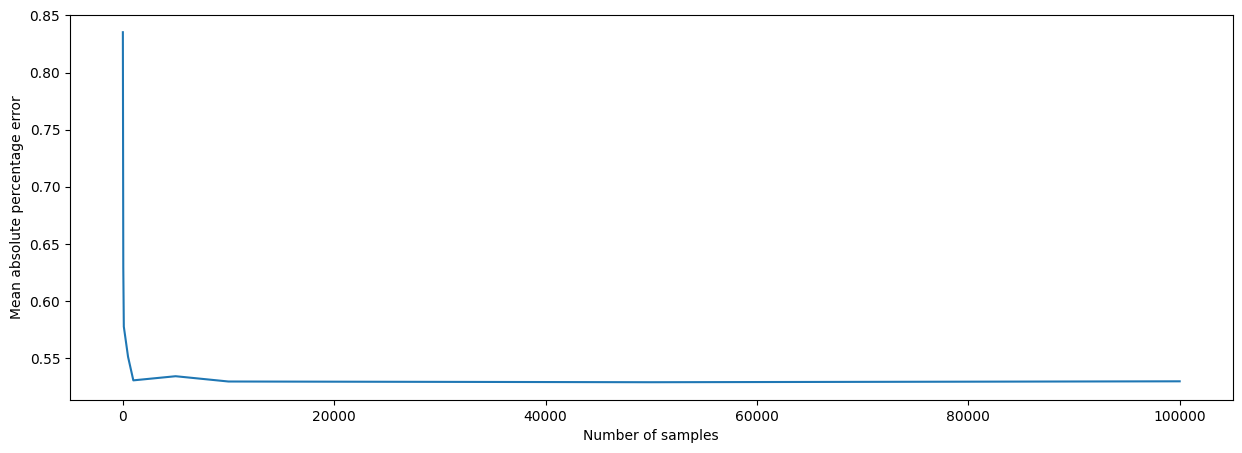

In [28]:
import matplotlib.pyplot as plt

x = [10,50,100,500,1000,5000,10000,50000,100000]
y = []

for m in x:
  approx_shapley = [elem[1] for elem in sorted(shapley_montecarlo(v, m).items(), key=lambda x: x[1])]
  exact_shapley = airport_game_shapley_value(cost_list)

  y.append(mape(exact_shapley, approx_shapley))

plt.plot(x, y)
#wider image
plt.gcf().set_size_inches(15, 5)
plt.xlabel('Number of samples')
plt.ylabel('Mean absolute percentage error')
plt.show()

# Induced Subgraph Games
Induced subgraph games are a compact way to represent a particular class of coalitional games with a specific form for the characteristic function. An induced subgraph is a tuple $\mathcal{G}(V, E, \mathbf{w})$ where $V$ is the set of nodes, or vertices, of the graph, $E$ is the set of edges, and $\mathbf{w}$ is a vector of weights on the edges. In such a graph, players are represented as nodes, edges represent coalitions of two players and weights represent the value of the coalition between any two players. Self loops are allowed in order to express the value of a player. In induced subgraph games, the value of a coalition $C \subseteq N$ is given by the sum of the weights $w_{ij}$ in the graph whose components are all contained in $C$. That is:

$$v(C) = \sum_{\{i,j\} \subseteq C} w_{ij}$$

This representation is useful to model interactions between the players in social networks. With this representation it is also possible to express whether any two players are in a synergical relation &ndash; for instance, when two players are together their value is higher than the sum of their values taken singualarly &ndash; or if they are in a detrimental relation, such as a situation in which when two player are together they obstacolate each other and lower their value.

In induced subgraph games, the computation of the Shapley value for a player $i$ is given by $v(\{i\})$ plus half of the sum of all the edges adjacent to $i$. That is:

$$\phi_i = w_{ii} + \frac{1}{2} \sum_{j \in \Gamma(i)} w_{ij}$$

where $\Gamma(i)$ is the neighbourhood function, which returns all the nodes $j$ adjacent to $i$.

Induced subgraph games allow us to represent many games, but not all games. For instance, the ariport game we have seen before cannot be represented as an induced subgraph game.</br>
In order to implement induced subgraph games in Python, we can use one of the libraries that implement graphs data structures and graph algorithms. A very good library, to this extent, is NetworkX: a library for graph data processing and analysis, which implements many graph algorithms and functions for social network analysis. It offers an easy to use and intuitive API, which makes working with graph data extremely simple. Being purely written in Python, however, it is not the fastest library available. If you are interested in sensibly faster graph processing and analysis libraries, please consider iGraph, NetworKit, or graph-tool.</br>
You can find the documentation of NetworkX here: https://networkx.org/documentation/stable/index.html

In [11]:
import networkx as nx

Now, we create a random graph with random edge weights; subsequently we will compute the Shapley values for the induced subgraph game, with the formula we have seen above. We will then translate the graph into a characteristic function and we will use the generic exponential formula to compute the Shapley value, in order to confirm that the Shapley values computed with both formula are, in fact, the same.

In [12]:
# We create a random graph (also known as Erdos-Renyi model) G, with 10 nodes and 25 edges.
# An undirected graph with N nodes can have at most (N*(N+1))/2 edges, if we exclude self-loops; N + (N*(N+1))/2 edges if we include self loops. In ourt case, we could have up to 65 edges, including self-loops. If two players are not connected with an edge, their coalition has value 0.
# The following command does not create self-loops.
G = nx.gnm_random_graph(10, 25)

# Let's add a self-loop for each node
for node in G.nodes():
    G.add_edge(node, node)

In [16]:
# The function G.edges() returns a list of tuples in the format (source_node, destination_node).
# Each edge offers a dictionary where we can store information about the edge.
# We can access the dictionary of each edge as follows: G.edges[source_node, destination_node]
# We can use the dictionary of edge attributes to assign each edge a random weight as an integer between 0 and 100
for i,j in G.edges():
    G.edges[i,j]['weight'] = random.randint(1,100)

# To retrieve the data in the dictionary we have to specify "data=True" in the function G.edges.
for e in G.edges(data=True):
    print(e)

(0, 8, {'weight': 51})
(0, 6, {'weight': 41})
(0, 3, {'weight': 2})
(0, 1, {'weight': 4})
(0, 0, {'weight': 58})
(1, 7, {'weight': 33})
(1, 4, {'weight': 50})
(1, 2, {'weight': 94})
(1, 9, {'weight': 97})
(1, 8, {'weight': 33})
(1, 5, {'weight': 78})
(1, 1, {'weight': 96})
(2, 6, {'weight': 84})
(2, 7, {'weight': 80})
(2, 5, {'weight': 71})
(2, 3, {'weight': 7})
(2, 2, {'weight': 85})
(3, 5, {'weight': 54})
(3, 9, {'weight': 35})
(3, 8, {'weight': 15})
(3, 7, {'weight': 69})
(3, 3, {'weight': 78})
(4, 5, {'weight': 57})
(4, 4, {'weight': 99})
(5, 7, {'weight': 57})
(5, 6, {'weight': 14})
(5, 8, {'weight': 75})
(5, 9, {'weight': 58})
(5, 5, {'weight': 56})
(6, 7, {'weight': 63})
(6, 6, {'weight': 82})
(7, 9, {'weight': 86})
(7, 7, {'weight': 60})
(8, 8, {'weight': 65})
(9, 9, {'weight': 61})


Now, lets implement a function to compute the value of a coalition for induced subgraph games.

In [17]:
def ISG_coalition_value(graph, coalition):
    value = 0
    for i,j in graph.edges():
      weight = graph.edges[i,j]['weight']
      if i in coalition and j in coalition:
        value += weight
    return value

In [18]:
ISG_coalition_value(G, {0,1,2,5})

542

Let's write a function to compute the Shapley value for the ISG

In [19]:
def ISG_shapley_value(graph):
    shapley_values = {node: 0 for node in graph.nodes()}

    for node in graph.nodes():
      try:
        self_loop_weight = graph.edges[node,node]['weight']
      except:
        self_loop_weight = 0
      shapley_values[node] = self_loop_weight + (1/2) * \
      sum([graph.edges[i,j]['weight'] for i,j in graph.edges if (i == node or j == node) and i != j])
    return shapley_values

In [20]:
ISG_shapley_value(G)

{0: 107.0,
 1: 290.5,
 2: 253.0,
 3: 169.0,
 4: 152.5,
 5: 288.0,
 6: 183.0,
 7: 254.0,
 8: 152.0,
 9: 199.0}

Let's define now a function to convert the induced subgraph game into a characteristic function game (CFG). As usual, we first generate all the possible coalitions. Then we compute the value of each coalition and organise everyting in a dictionary.
The following one-liner does everything!

In [21]:
def from_ISG_to_CFG(graph):
    return {coalition : (ISG_coalition_value(graph, coalition) if coalition != frozenset() else 0) for coalition in powerset(graph.nodes)}

In [22]:
v = from_ISG_to_CFG(G)
print(v)
print(shapley(v))
# Let's check that Shapley values computed with the ISG formula are the same Shapley value computed with the CFG formula
if all([round(isg_s, 10) == round(cfg_s, 10) for isg_s, cfg_s in zip(shapley(v).values(), ISG_shapley_value(G).values())]):
    print("The Shapley values are the same!")

{frozenset({0}): 58, frozenset({1}): 96, frozenset({2}): 85, frozenset({3}): 78, frozenset({4}): 99, frozenset({5}): 56, frozenset({6}): 82, frozenset({7}): 60, frozenset({8}): 65, frozenset({9}): 61, frozenset({0, 1}): 158, frozenset({0, 2}): 143, frozenset({0, 3}): 138, frozenset({0, 4}): 157, frozenset({0, 5}): 114, frozenset({0, 6}): 181, frozenset({0, 7}): 118, frozenset({0, 8}): 174, frozenset({0, 9}): 119, frozenset({1, 2}): 275, frozenset({1, 3}): 174, frozenset({1, 4}): 245, frozenset({1, 5}): 230, frozenset({1, 6}): 178, frozenset({1, 7}): 189, frozenset({8, 1}): 194, frozenset({1, 9}): 254, frozenset({2, 3}): 170, frozenset({2, 4}): 184, frozenset({2, 5}): 212, frozenset({2, 6}): 251, frozenset({2, 7}): 225, frozenset({8, 2}): 150, frozenset({9, 2}): 146, frozenset({3, 4}): 177, frozenset({3, 5}): 188, frozenset({3, 6}): 160, frozenset({3, 7}): 207, frozenset({8, 3}): 158, frozenset({9, 3}): 174, frozenset({4, 5}): 212, frozenset({4, 6}): 181, frozenset({4, 7}): 159, frozens

In [23]:
# Here is the beauty of compact representation. Our game can be represented with just 35 edges and weights on a graph with 10 nodes. The naive representation stores 1023 values!
import sys
print('The compact ISG representation uses %d bytes' %sys.getsizeof(G))
print('The naive CFG representation uses %d bytes' %sys.getsizeof(v))

The compact ISG representation uses 48 bytes
The naive CFG representation uses 36960 bytes


# Marginal Contribution Nets
The last compact representation that we will study is the Marginal Contribution Nets (MC-nets, in short)<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1). This compact representation uses a logic approach to represent games and can be seen as an extension of the induced subgraph games representation.</br>
MC-nets represent coalitional games using sets of *rules* in the following syntactic form:

$$Pattern \longrightarrow value$$

The value associated with a pattern is the marginal contribution of that pattern. A rule applies to a set of players $S$ if $S$ meets the requirements of the $Pattern$. These patterns can be represented by any logical formula over the players; but, in its most basic form, a pattern is a conjunction of players. $S$ meets the requirements of a given pattern if $S$ is a superset of it. The value of $S$ is defined as the sum over the values of all the rules that apply to $S$.

For instance, let's consider the following game represented as an MC-net:

$$
    \begin{aligned}
        \{a \land b \} \longrightarrow 5 \\
        \{ b \} \longrightarrow 2
    \end{aligned}
$$

This game encodes the following characteristic function:

$$ v(\emptyset) = 0, \qquad v(\{a\}) = 0, \qquad v(\{b\}) = 2, \qquad v(\{a,b\}) = 5 + 2 = 7 $$

Now, it is possible to show that if we allow negative values or negative literals in the patterns (i.e. rules such as $\{p \land \neg q \longrightarrow value\}$), MC-nets can represent any coalitional game. Therefore, this compact representation is complete!

MC-nets have a graphical interpretation. Each rule describes a clique (that is, a fully connected graph) where the nodes are the players in the pattern and the edges of the clique are weighted accordingly to the value associated with said pattern. More interestingly, however, MC-nets can naturally be represented as hypergraphs. Hypergraphs are generalisations of graphs, where hyperedges can connect more than two nodes at once. In the hypergraph representation, each pattern is an hyperedge weighted with the value associated to said pattern. As such, the MC-net is a natural generalisation of the induced subgraph game representation we have seen before. Since we can treat each rule as a standalone game, in order to compute the Shapley value for the whole game we can take advantage of the additivity property of the Shapley values. We can compute the Shapley value of a player in an MC-net representation by summing over the Shapley values for said player computed for each rule. If we allow for negative values, we can compute the Shapley value of a player $i$ as follows:

$$\phi_i = \sum_{\varphi \longrightarrow x \in rs_i} \frac{x}{|\varphi|}$$

where $\varphi \longrightarrow x$ is a rule in the form $Pattern \longrightarrow value$; $rs_i$ is the set of rules that apply to player $i$, and $|\varphi|$ is the cardinality (i.e. the number of players) of the pattern $\varphi$.

While in Python there are many libraries for graph analysis and manipulation, the same could not be said for hypergraphs, until some years ago. I have recently found that, since 2020, two Python libraries for hypergraph analysis and manipulation have been developed: HyperNetX, and hypergraphx. These libraries seem to be quite well developed, well maintained, and stable. So, we could implement MC-nets directly as hypergraphs. However, we will take a different, more naive, approach to implement MC-nets. I leave it to you, as a self-study homework, to implement MC-nets as hypergraphs.</br>
In the following, we are going to implement MC-nets simply as sets of rules. Each rule will be encoded as a couple $(P, v)$ where $P$ is a set of players, intended as a conjunction of players, and $v$ is the value associated with $P$; $v$ can also be negative, so we can represent any game. As usual, we will implement a function to get the value of a coalition and a function to compute the Shapley values.


<hr style="width:5%;text-align:left;margin-left:0">

<a name=\cite_note-1\></a>1. [^](#cite_ref-1): Ieong, S., & Shoham, Y. (2005, June). Marginal contribution nets: a compact representation scheme for coalitional games. In Proceedings of the 6th ACM Conference on Electronic Commerce (pp. 193-202).

In [29]:
# We can represent the airport game defined by the cost vector c=(5, 7, 10) as follow.
MC_net = [
    ({"A"}, 5),
    ({"B"}, 7),
    ({"C"}, 10),
    ({"A", "B"}, -5),
    ({"A", "C"}, -5),
    ({"B", "C"}, -7),
    ({"A", "B", "C"}, 5)
]

In [30]:
# To find the value of a coalition we need to iterate through all the rules in the MC-net and adding all the values for the rules which apply.
# A rule applies to a coalition if the coalition is a superset of the pattern. Sets, in Python, provide such a function.
coalition = set(["A", "B", "C"])
for rule in MC_net:
    if coalition.issuperset(rule[0]):
        print(coalition, 'is a superset of', rule[0])

{'B', 'A', 'C'} is a superset of {'A'}
{'B', 'A', 'C'} is a superset of {'B'}
{'B', 'A', 'C'} is a superset of {'C'}
{'B', 'A', 'C'} is a superset of {'B', 'A'}
{'B', 'A', 'C'} is a superset of {'A', 'C'}
{'B', 'A', 'C'} is a superset of {'B', 'C'}
{'B', 'A', 'C'} is a superset of {'B', 'A', 'C'}


In [32]:
# A function to compute the value of a coalition
def MC_net_coalition_value(MC_net, coalition):
    value = 0
    for rule in MC_net:
      if coalition.issuperset(rule[0]):
        value += rule[1]
    return value

In [52]:
# A function to compute the Shapley value for MC-nets
def extract_players(MC_net):
    return [list(rule[0])[0] for rule in MC_net if len(rule[0]) == 1]

def MC_net_shapley_value(MC_net):
    players_list = extract_players(MC_net)
    shapley_values = {player: 0 for player in players_list}

    for player in players_list:
      for rule in MC_net:
        if rule[0].issuperset(set(player)):
          shapley_values[player] += rule[1]/len(rule[0])

    return shapley_values

In [48]:
MC_net_coalition_value(MC_net, {"A", "C"})

10

Similarly to what we have done for the induced subgraph games, we now write a function to transform an MC-net into a characteristic function.
As usual, we just need to generate all the partitions of the set of players, compute their value, and organise everything in a dictionary.
This results in another one-liner.

In [47]:
def from_MC_net_to_CFG(MC_net):
    return {coalition : (MC_net_coalition_value(MC_net, set(coalition)) if coalition != frozenset() else 0) for coalition in powerset(max(MC_net)[0])}

In [49]:
v = from_MC_net_to_CFG(MC_net)

In [50]:
shapley(v)

{'B': 2.6666666667, 'A': 1.6666666667, 'C': 5.6666666667}

In [53]:
MC_net_shapley_value(MC_net)

{'A': 1.6666666666666667, 'B': 2.666666666666667, 'C': 5.666666666666667}